In [85]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from scipy.interpolate import interp1d
from scipy.optimize import minimize

In [86]:
## Neural network tools
def get_batches(arrays, batch_size=None, randomise=False, include_remainder=True):
    length = len(arrays[0])
    idx = np.arange(length)

    if randomise:
        np.random.shuffle(idx)

    n_full_batches = length // batch_size
    is_remainder = (length % batch_size > 0)

    if is_remainder and include_remainder:
        n_batches = n_full_batches + 1
    else:
        n_batches = n_full_batches

    for i_batch in range(n_batches):
        if i_batch < n_full_batches:
            batch_idx = idx[i_batch*batch_size:(i_batch+1)*batch_size]
        else:
            batch_idx = idx[i_batch*batch_size:]

        arrays_batch = [torch.Tensor(array[batch_idx]) for array in arrays]
        yield arrays_batch

def get_total_loss(model, loss, X, y, w):
    eval_batch_size = min(1024*2**8,len(X))
    losses = [] # contain loss from every batch

    with torch.no_grad():
        for X_tensor, y_tensor, w_tensor in get_batches([X, y, w], eval_batch_size):
            output = model(X_tensor)
            l = loss(output, y_tensor)
            # Apply weighted loss
            l = (l * w_tensor).sum() / w_tensor.sum()
            losses.append(l)

        mean_loss = sum(losses) / len(X)

    return mean_loss

def get_network_output(df, features, model):
    with torch.no_grad():
        X = df[features].to_numpy() #Now check what corrections are for test_df

        #eval_batch_size = min(1024*2**8,len(df))
        eval_batch_size = min(1024,len(df))
        outputs = []

        for X_tensor, in get_batches([X], eval_batch_size):
              outputs.append(model(X_tensor).numpy())

        output = np.concatenate(outputs)

    return output

In [87]:
# Load data and apply selection
df = pd.read_csv("fitting_output.csv")

# Apply selections
mask = (df['diphotonMass']>100)&(df['diphotonMass']<=180)
df = df[mask]

In [88]:
# Include diphotonMass explicitly as a variable
x = ['leadPhotonPtoM', 'leadPhotonEta', 'subleadPhotonPtoM',
       'subleadPhotonEta', 'subleadPhotonIDMVA', 'leadPhotonIDMVA',
       'leadJetEta', 'subleadJetPt', 'dijetMass', 'dijetPt',
       'dijetMinDRJetPho', 'leadJetDiphoDEta', 'subleadJetDiphoDPhi',
       'diphotonMass'
    ]

In [89]:
# Add transformed variables
mean = np.array(df[x].mean())
std = np.array(df[x].std())
vars_T = (df[x]-mean)/std
for v in x:
    df[f"{v}_T"] = vars_T[v]

In [90]:
# Calculate sum of weights = true yield
sumw = {}
sumw['bkg'] = df[df['Type']==0]['scaled_original_weight'].sum()
sumw['ggh'] = df[df['Type']==1]['scaled_original_weight'].sum()
sumw['vbf'] = df[df['Type']==2]['scaled_original_weight'].sum()

# Add train weight: smallest sample should have events with w=1, scale others down to match
N_classes = np.array([(df['Type']==0).sum(), (df['Type']==1).sum(), (df['Type']==2).sum()])
df['weight_train'] = (df['Type']==0)*(df['scaled_original_weight']/sumw['bkg'] * N_classes.min()) + \
(df['Type']==1)*(df['scaled_original_weight']/sumw['ggh'] * N_classes.min()) + \
(df['Type']==2)*(df['scaled_original_weight']/sumw['vbf'] * N_classes.min())

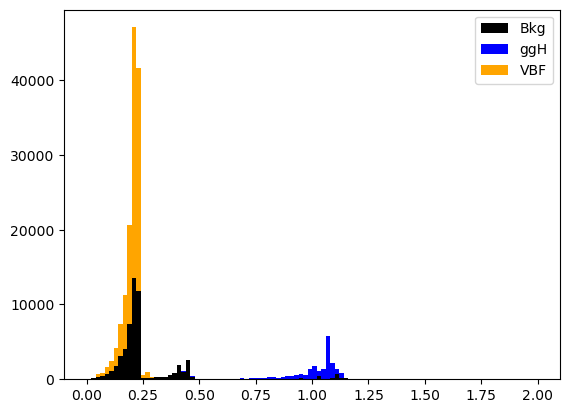

In [97]:
# Plot distribution of training weights
fig, ax = plt.subplots()
h = ax.hist([df[df['Type']==0]['weight_train'],df[df['Type']==1]['weight_train'],df[df['Type']==2]['weight_train']], 
        bins=100, range=(0,2), 
        label=['Bkg','ggH','VBF'], color=['black','blue','orange'], 
        stacked=True
       )
ax.legend(loc='best')

In [98]:
# Add one-hot encoded labels
df['is_bkg'] = df['Type']==0
df['is_ggh'] = df['Type']==1
df['is_vbf'] = df['Type']==2

In [99]:
# Make separate dataframe for each class
dfs = {}
dfs['bkg'] = df[df['Type']==0]
dfs['ggh'] = df[df['Type']==1]
dfs['vbf'] = df[df['Type']==2]

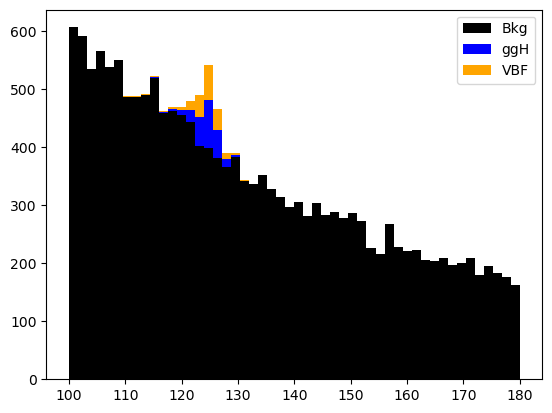

In [100]:
# Plot diphoton mass distribution
fig, ax = plt.subplots()
h = ax.hist([dfs['bkg']['diphotonMass'],dfs['ggh']['diphotonMass'],dfs['vbf']['diphotonMass']], 
        bins=50, range=(100,180), 
        label=['Bkg','ggH','VBF'], color=['black','blue','orange'], 
        weights=[dfs['bkg']['scaled_original_weight'],dfs['ggh']['scaled_original_weight'],dfs['vbf']['scaled_original_weight']],
        stacked=True
       )
ax.legend(loc='best')

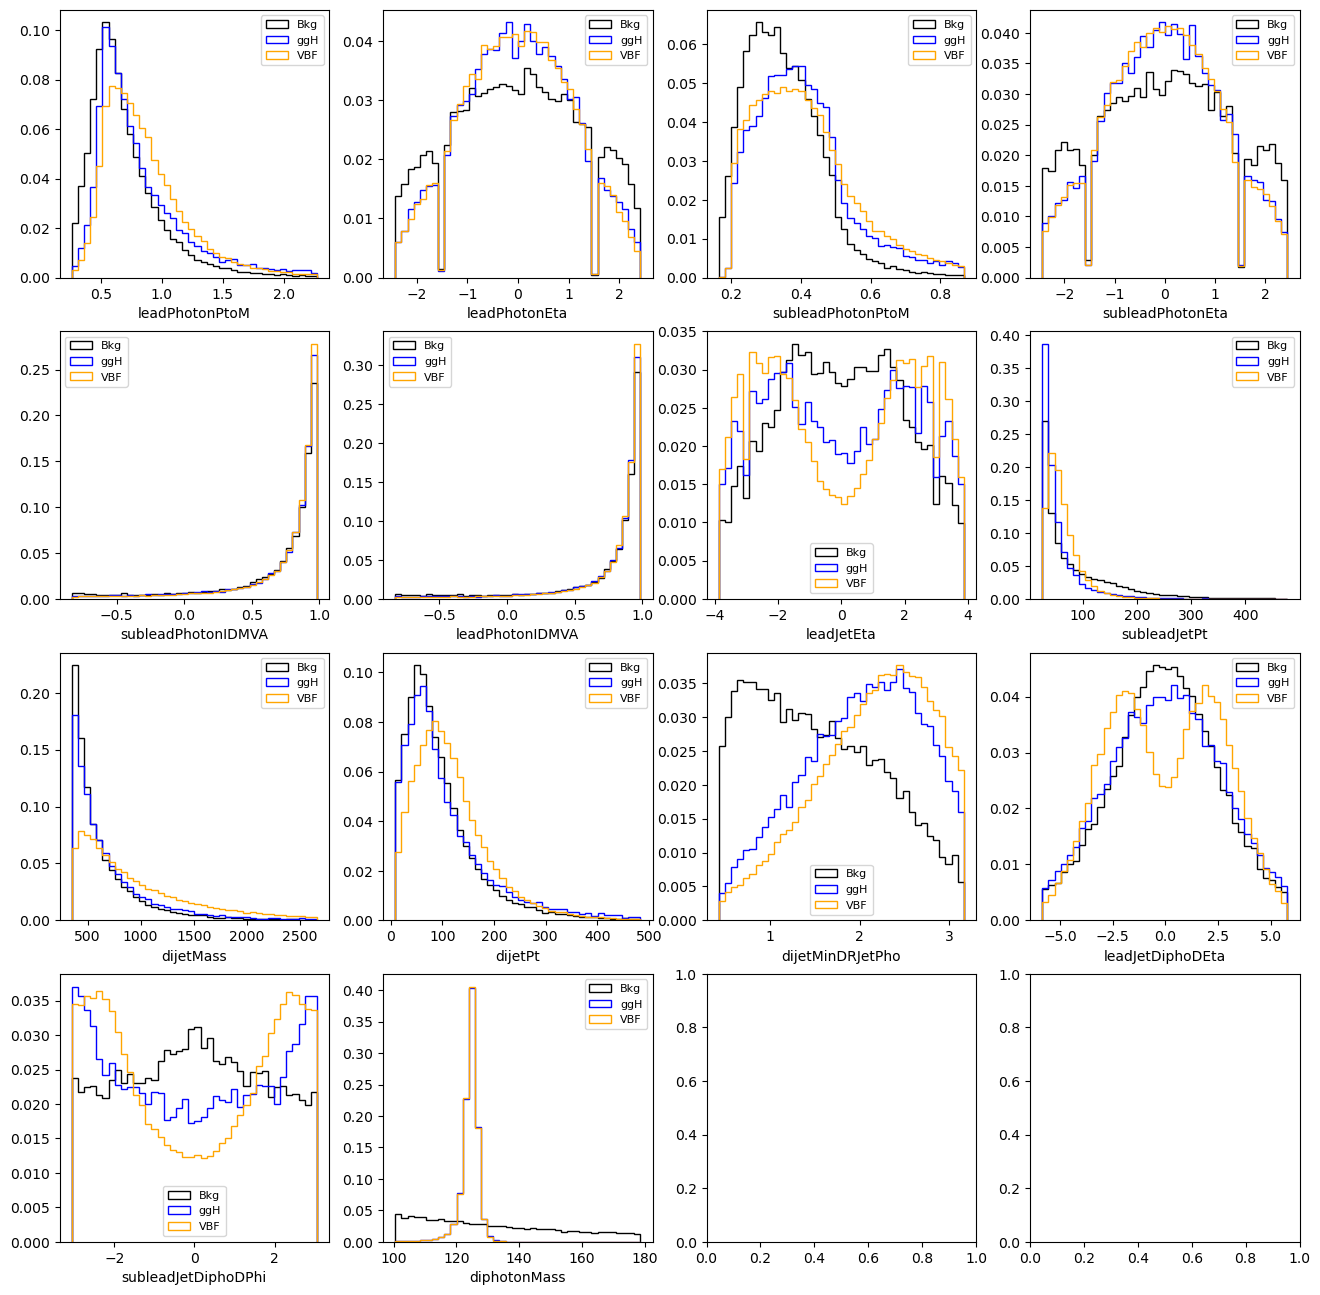

In [101]:
# Plot features
fig, axs = plt.subplots(4,4, figsize=(16,16))
for i in range(0,4):
    for j in range(0,4):
        k = i*4+j
        if k > 13: continue
        x_range = np.percentile(dfs['bkg'][x[k]],1), np.percentile(dfs['bkg'][x[k]],99)
        h_bkg = axs[i][j].hist(dfs['bkg'][x[k]], bins=40, range=x_range, histtype='step', color='black', weights=dfs['bkg']['scaled_original_weight']/sumw['bkg'], label='Bkg')
        h_ggh = axs[i][j].hist(dfs['ggh'][x[k]], bins=40, range=x_range, histtype='step', color='blue', weights=dfs['ggh']['scaled_original_weight']/sumw['ggh'], label='ggH')
        h_vbf = axs[i][j].hist(dfs['vbf'][x[k]], bins=40, range=x_range, histtype='step', color='orange', weights=dfs['vbf']['scaled_original_weight']/sumw['vbf'], label='VBF')
        axs[i][j].set_xlabel(x[k])
        axs[i][j].legend(loc='best', fontsize=8)

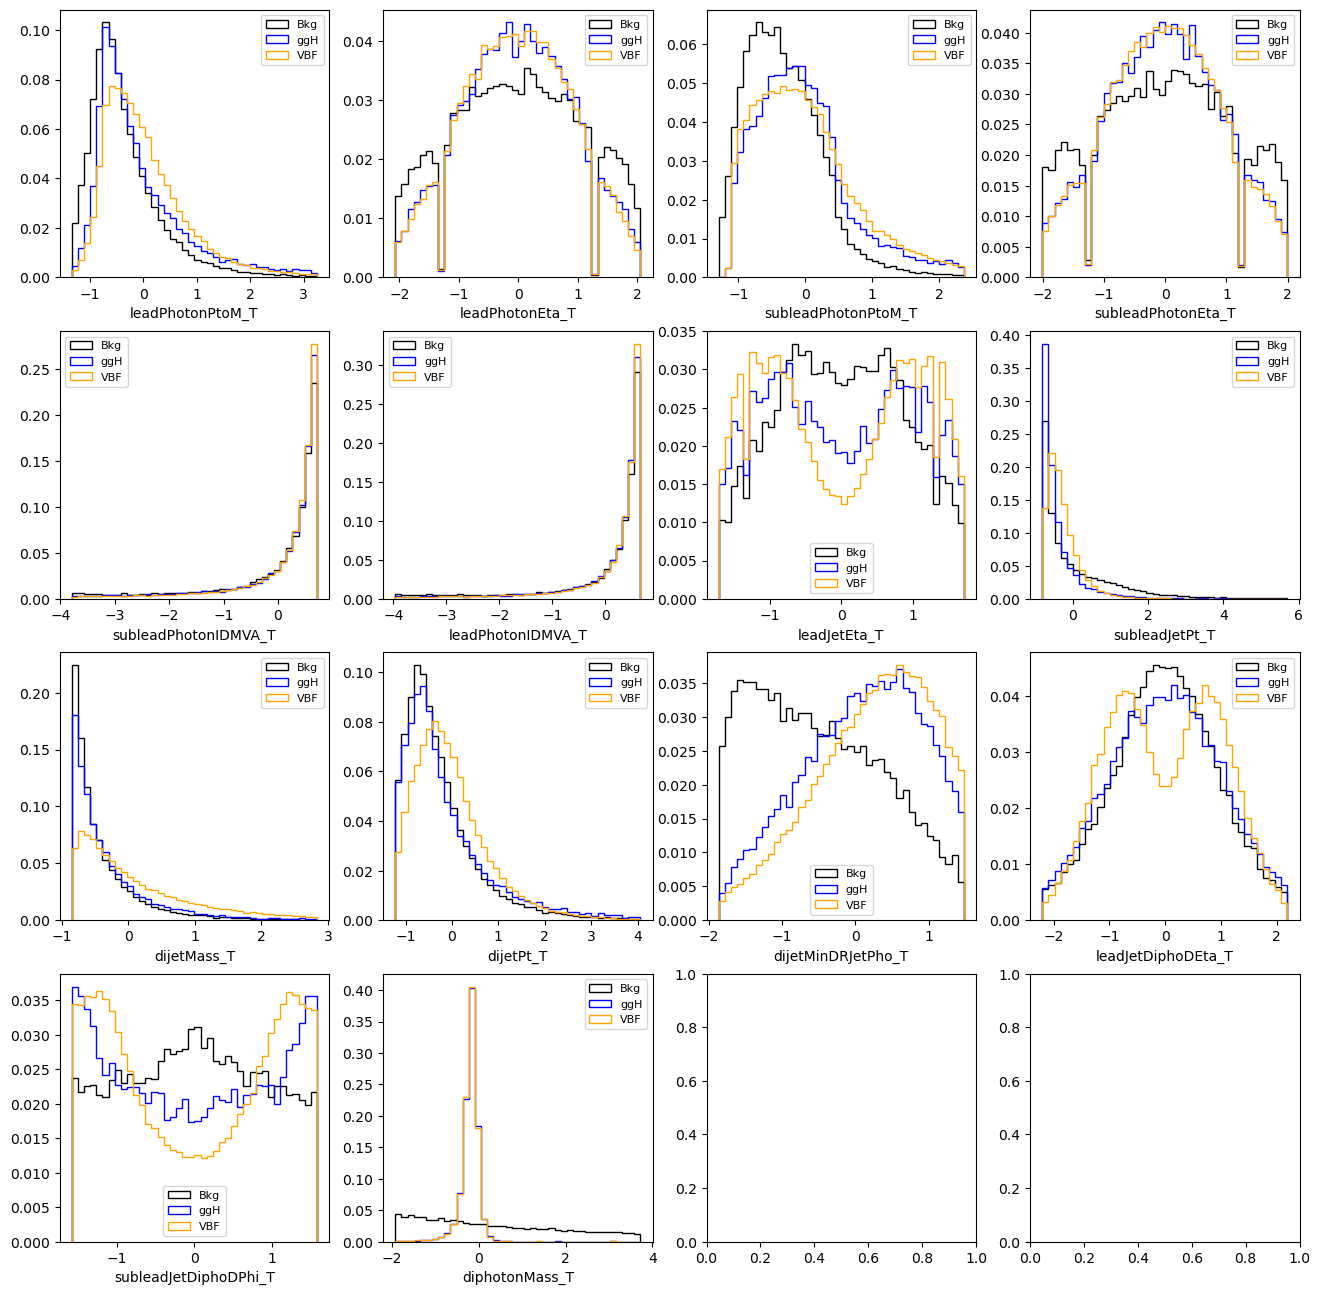

In [102]:
# Plot transformed features
fig, axs = plt.subplots(4,4, figsize=(16,16))
for i in range(0,4):
    for j in range(0,4):
        k = i*4+j
        if k > 13: continue
        xT = f"{x[k]}_T"
        x_range = np.percentile(dfs['bkg'][xT],1), np.percentile(dfs['bkg'][xT],99)
        h_bkg = axs[i][j].hist(dfs['bkg'][xT], bins=40, range=x_range, histtype='step', color='black', weights=dfs['bkg']['scaled_original_weight']/sumw['bkg'], label='Bkg')
        h_ggh = axs[i][j].hist(dfs['ggh'][xT], bins=40, range=x_range, histtype='step', color='blue', weights=dfs['ggh']['scaled_original_weight']/sumw['ggh'], label='ggH')
        h_vbf = axs[i][j].hist(dfs['vbf'][xT], bins=40, range=x_range, histtype='step', color='orange', weights=dfs['vbf']['scaled_original_weight']/sumw['vbf'], label='VBF')
        axs[i][j].set_xlabel(xT)
        axs[i][j].legend(loc='best', fontsize=8)

In [107]:
# Do test-train split of datasets: 50/50
bkg_train, bkg_test = train_test_split(dfs['bkg'], test_size=0.5, random_state=train_hp['seed'])
ggh_train, ggh_test = train_test_split(dfs['ggh'], test_size=0.5, random_state=train_hp['seed'])
vbf_train, vbf_test = train_test_split(dfs['vbf'], test_size=0.5, random_state=train_hp['seed'])
train_df = pd.concat([bkg_train, ggh_train, vbf_train]).sample(frac=1)
test_df = pd.concat([bkg_test, ggh_test, vbf_test]).sample(frac=1)

In [109]:
# Features for training networks: use transformed variables
features = [f"{v}_T" for v in x]

### Cross-entropy loss network

Train a three-class network with a weighted CE loss for baseline. Network labelling events as either bkg, ggH or VBF.

In [103]:
# Training hyperparameters
train_hp = {
    "lr":0.0001,
    "batch_size":128,
    "N_epochs":100,
    "seed":0
}

# Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(train_hp['seed'])

In [105]:
class Net(nn.Module):
    def __init__(self, n_features=len(x), nodes=[100,100], output_nodes=3):
        super(Net, self).__init__()
        # Build network
        n_nodes = [n_features] + nodes + [output_nodes]
        self.layers = nn.ModuleList()
        for i in range(len(n_nodes)-1):
            self.layers.append(nn.Linear(n_nodes[i], n_nodes[i+1]))
            self.layers.append(nn.ReLU())

    def forward(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        # Apply softmax
        return torch.softmax(out, dim=1)

    # Add function of network to do the categorisation i.e. put events in the category ("predicted label") according to max prob
    def probmax(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        # Apply argmax
        return torch.argmax(out, dim=1)

In [108]:
# Function to train network with cross entropy loss
def train_network_cross_entropy(model, train_df, test_df, features=['diphotonMass'], labels=['is_bkg','is_ggh','is_vbf'], weight_var="weight_train", train_hp={}):
    optimiser = torch.optim.Adam(model.parameters(), lr=train_hp["lr"])

    X_train = train_df[features].to_numpy()
    X_test = test_df[features].to_numpy()
    y_train = train_df[labels].to_numpy()
    y_test = test_df[labels].to_numpy()
    w_train = train_df[weight_var].to_numpy()
    w_test = test_df[weight_var].to_numpy()

    ce_loss = nn.CrossEntropyLoss(reduction='none')
    train_loss, test_loss = [], []

    print(">> Training...")
    with tqdm(range(train_hp["N_epochs"])) as t:
        for i_epoch in t:
            model.train()

            batch_gen = get_batches([X_train, y_train, w_train], batch_size=train_hp['batch_size'],
                                    randomise=True, include_remainder=False
                                   )
            
            for X_tensor, y_tensor, w_tensor in batch_gen:
                optimiser.zero_grad()
                output = model(X_tensor)
                loss = ce_loss(output, y_tensor)
                # Apply weighted loss
                loss = (loss * w_tensor).sum() / w_tensor.sum()
                loss.backward()
                optimiser.step()

            model.eval()
            # "get_total_loss": function defined in statml_tools.py to evaluate the network in batches (useful for large datasets)
            train_loss.append(get_total_loss(model, ce_loss, X_train, y_train, w_train))
            test_loss.append(get_total_loss(model, ce_loss, X_test, y_test, w_test))
            t.set_postfix(train_loss=train_loss[-1], test_loss=test_loss[-1])

    print(">> Training finished")
    model.eval()

    return model, train_loss, test_loss

In [110]:
# Initialise network
model_ce = Net(n_features=len(x), nodes=[100,100], output_nodes=3)

In [111]:
model_ce, train_loss_ce, test_loss_ce = train_network_cross_entropy(model_ce, train_df, test_df, features=features, labels=['is_bkg','is_ggh','is_vbf'], weight_var="weight_train", train_hp=train_hp)

>> Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it, test_loss=tensor(9.3787e-06), train_loss=tensor(9.1895e-06)]

>> Training finished


Text(0, 0.5, 'CE loss')

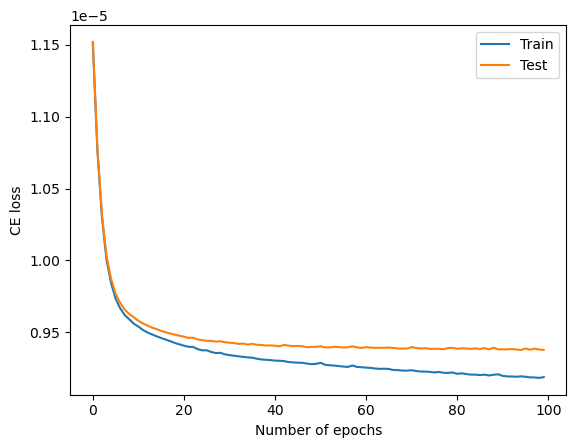

In [112]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_ce, label="Train")
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_ce, label="Test")
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("CE loss")

In [113]:
# Add output class probability to events 
df['prob_bkg'] = model_ce(torch.Tensor(df[features].to_numpy())).T[0].detach().numpy()
df['prob_ggh'] = model_ce(torch.Tensor(df[features].to_numpy())).T[1].detach().numpy()
df['prob_vbf'] = model_ce(torch.Tensor(df[features].to_numpy())).T[2].detach().numpy()
df['category'] = model_ce.probmax(torch.Tensor(df[features].to_numpy())).detach().numpy()

Text(0.5, 0, 'Prob(vbf)')

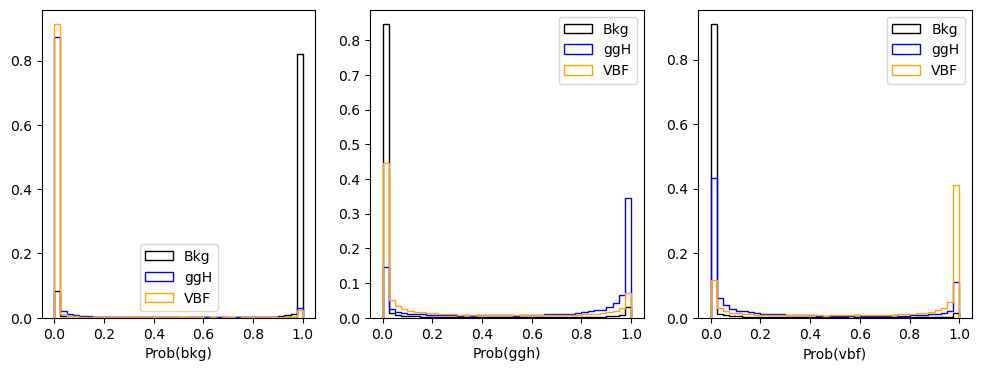

In [114]:
# Plot output probabilities for each truth class
fig, axs = plt.subplots(1,3, figsize=(12,4))
mask_bkg = df['Type']==0
mask_ggh = df['Type']==1
mask_vbf = df['Type']==2

h = axs[0].hist(df[mask_bkg]['prob_bkg'], bins=40, range=(0,1), color='black', histtype='step', label='Bkg', weights=df[mask_bkg]['scaled_original_weight']/sumw['bkg'])
h = axs[0].hist(df[mask_ggh]['prob_bkg'], bins=40, range=(0,1), color='blue', histtype='step', label='ggH', weights=df[mask_ggh]['scaled_original_weight']/sumw['ggh'])
h = axs[0].hist(df[mask_vbf]['prob_bkg'], bins=40, range=(0,1), color='orange', histtype='step', label='VBF', weights=df[mask_vbf]['scaled_original_weight']/sumw['vbf'])
axs[0].legend(loc='best')
axs[0].set_xlabel("Prob(bkg)")

h = axs[1].hist(df[mask_bkg]['prob_ggh'], bins=40, range=(0,1), color='black', histtype='step', label='Bkg', weights=df[mask_bkg]['scaled_original_weight']/sumw['bkg'])
h = axs[1].hist(df[mask_ggh]['prob_ggh'], bins=40, range=(0,1), color='blue', histtype='step', label='ggH', weights=df[mask_ggh]['scaled_original_weight']/sumw['ggh'])
h = axs[1].hist(df[mask_vbf]['prob_ggh'], bins=40, range=(0,1), color='orange', histtype='step', label='VBF', weights=df[mask_vbf]['scaled_original_weight']/sumw['vbf'])
axs[1].legend(loc='best')
axs[1].set_xlabel("Prob(ggh)")

h = axs[2].hist(df[mask_bkg]['prob_vbf'], bins=40, range=(0,1), color='black', histtype='step', label='Bkg', weights=df[mask_bkg]['scaled_original_weight']/sumw['bkg'])
h = axs[2].hist(df[mask_ggh]['prob_vbf'], bins=40, range=(0,1), color='blue', histtype='step', label='ggH', weights=df[mask_ggh]['scaled_original_weight']/sumw['ggh'])
h = axs[2].hist(df[mask_vbf]['prob_vbf'], bins=40, range=(0,1), color='orange', histtype='step', label='VBF', weights=df[mask_vbf]['scaled_original_weight']/sumw['vbf'])
axs[2].legend(loc='best')
axs[2].set_xlabel("Prob(vbf)")

Text(0, 0.5, 'Prob(vbf)')

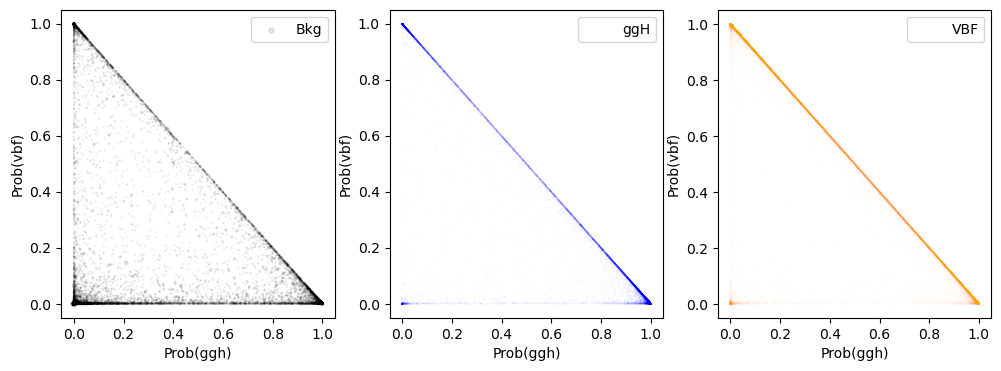

In [115]:
# Plot prob(ggH) - vs - prob(vbf) for each of the truth classes. Prob(bkg) = 1-prob(ggh)-prob(vbf). 
# Expect bkg to be more concentrated to bottom left
# ggH towards bottom right
# VBF towards top left
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].scatter(df[mask_bkg]['prob_ggh'], df[mask_bkg]['prob_vbf'], s=df[mask_bkg]['scaled_original_weight'], alpha=0.1, c='black', label='Bkg')
axs[0].legend(loc='upper right')
axs[0].set_xlabel("Prob(ggh)")
axs[0].set_ylabel("Prob(vbf)")

axs[1].scatter(df[mask_ggh]['prob_ggh'], df[mask_ggh]['prob_vbf'], s=df[mask_ggh]['scaled_original_weight'], alpha=0.1, c='blue', label='ggH')
axs[1].legend(loc='upper right')
axs[1].set_xlabel("Prob(ggh)")
axs[1].set_ylabel("Prob(vbf)")

axs[2].scatter(df[mask_vbf]['prob_ggh'], df[mask_vbf]['prob_vbf'], s=df[mask_vbf]['scaled_original_weight'], alpha=0.1, c='orange', label='VBF')
axs[2].legend(loc='upper right')
axs[2].set_xlabel("Prob(ggh)")
axs[2].set_ylabel("Prob(vbf)")

### NLL calculation 
Categorise events according to the max probability.

Calculate yields in each event category from the different truth processes.

As we included `'diphotonMass'` as an input feature then we do not fit it here! We just fit the yield in each category.

As we are using the test datasets, we need to calculate a weight factor (wf) to make sure the sum of weights is equal to what you would expect in the total dataset. These are effectively = 2 due to the 50/50 test-train split.

In [119]:
wf = {}
wf['bkg'] = sumw['bkg'] / bkg_test['scaled_original_weight'].sum()
wf['ggh'] = sumw['ggh'] / ggh_test['scaled_original_weight'].sum()
wf['vbf'] = sumw['vbf'] / vbf_test['scaled_original_weight'].sum()

In [120]:
# Categorise events according to max probability of output classes
bkg_test['category_ce'] = model_ce.probmax(torch.Tensor(bkg_test[features].to_numpy())).detach().numpy()
ggh_test['category_ce'] = model_ce.probmax(torch.Tensor(ggh_test[features].to_numpy())).detach().numpy()
vbf_test['category_ce'] = model_ce.probmax(torch.Tensor(vbf_test[features].to_numpy())).detach().numpy()

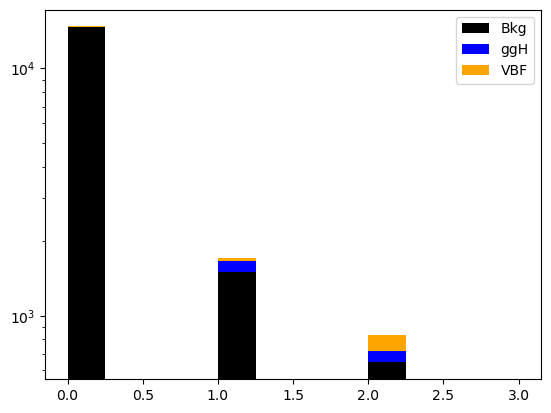

In [124]:
# Plot categories
fig, ax = plt.subplots()
h = ax.hist([bkg_test['category_ce'],ggh_test['category_ce'],vbf_test['category_ce']], 
        bins=12, range=(0,3), 
        label=['Bkg','ggH','VBF'], color=['black','blue','orange'], 
        weights=[bkg_test['scaled_original_weight']*wf['bkg'],ggh_test['scaled_original_weight']*wf['ggh'],vbf_test['scaled_original_weight']*wf['vbf']],
        stacked=True
       )
ax.legend(loc='best')
ax.set_yscale("log")

In [125]:
# Calculate yields landing in each category for the different truth classes: multiply by weight factor (~2) to get the true yields
yields = {}
yields['ce'] = {}
yields['ce']['bkg'] = np.array([])
yields['ce']['ggh'] = np.array([])
yields['ce']['vbf'] = np.array([])

for cat in [0,1,2]:
    yields['ce']['bkg'] = np.append( yields['ce']['bkg'], bkg_test[bkg_test['category']==cat]['scaled_original_weight'].sum()*wf['bkg'])
    yields['ce']['ggh'] = np.append( yields['ce']['ggh'], ggh_test[ggh_test['category']==cat]['scaled_original_weight'].sum()*wf['ggh'])
    yields['ce']['vbf'] = np.append( yields['ce']['vbf'], vbf_test[vbf_test['category']==cat]['scaled_original_weight'].sum()*wf['vbf'])

In [126]:
# Define function to calculate the NLL from yields
def NLL(yields, mu_ggh, mu_vbf, theta_init):
    counts_exp = yields['bkg'] + mu_ggh*yields['ggh'] + mu_vbf*yields['vbf']
    asimov = yields['bkg'] + theta_init['mu_ggh']*yields['ggh'] + theta_init['mu_vbf']*yields['vbf']
    mask = counts_exp!=0
    return -1*(asimov[mask]*np.log(counts_exp[mask])-counts_exp[mask]).sum()

# Function to extract 2NLL from array of NLL values
def TwoDeltaNLL(x):
    x = np.array(x)
    return 2*(x-x.min())

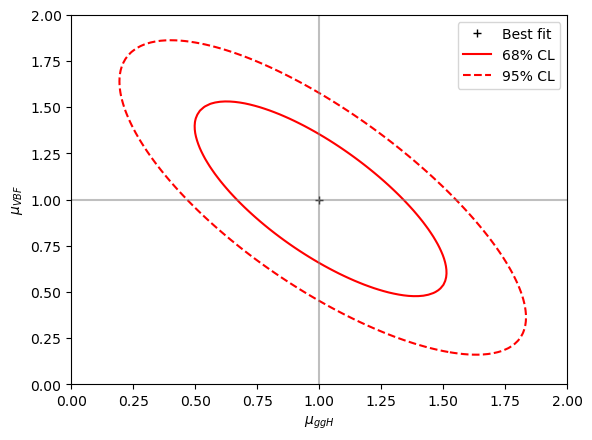

In [128]:
# Plot 2D NLL surface
nll = {}
theta_init = {'mu_ggh':1., 'mu_vbf':1.}
x = np.linspace(0,2,101)
y = np.linspace(0,2,101)
X,Y = np.meshgrid(x,y)
Z = []
for i in range(len(X)):
    z = []
    for j in range(len(X[i])):
        xval,yval = X[i][j], Y[i][j]
        z.append(NLL(yields['ce'], xval, yval, theta_init))
    Z.append(z)
nll['ce'] = np.array(Z)

fig, ax = plt.subplots()
cs = ax.contour(X,Y,TwoDeltaNLL(nll['ce']), levels=[2.3,5.99], colors=['red','red'], linestyles=['solid','dashed'])
i_bf, j_bf = np.unravel_index(TwoDeltaNLL(nll['ce']).argmin(), TwoDeltaNLL(nll['ce']).shape)
ax.plot(X[i_bf][j_bf], Y[i_bf][j_bf], marker='+', color='black', label='Best fit', ls='None')
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([],[], color='red', ls='solid'))
handles.append(plt.Line2D([],[], color='red', ls='dashed'))
labels.append("68% CL")
labels.append("95% CL")
ax.legend(handles, labels, loc='best')
ax.set_xlabel("$\mu_{ggH}$")
ax.set_ylabel("$\mu_{VBF}$")
ax.axhline(theta_init['mu_ggh'], color='grey', alpha=0.5)
ax.axvline(theta_init['mu_vbf'], color='grey', alpha=0.5)

### Inference-aware network

In [151]:
# Training hyperparameters
train_hp = {
    "lr":1e-4,
    "batch_size":2000,
    "N_epochs":300,
    "seed":0
}

# Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(train_hp['seed'])

### Key element
Make sure that within each batch, the sum of weights of each class will equal what one would expect for the full dataset

To do this we use the `sumw` dictionary which was defined at the start...

In [28]:
def hess_to_tensor(H):
    hess_elements = []
    for i in range(len(H)):
        for j in range(len(H)):
            hess_elements.append(H[i][j].reshape(1))
    return torch.cat(hess_elements).reshape(len(H),len(H))

def NLL_ia(mu_ggh, mu_vbf, theta_init, sumw, X, y, w, model):
    # Background asimov
    X_b = X[y==0]
    w_b = w[y==0]
    y_b = model(X_b)
    counts_b = torch.sum(y_b*w_b.unsqueeze(1), axis=0) * (sumw['bkg']/torch.sum(w_b, axis=0))

    # ggH asimov
    X_ggh = X[y==1]
    w_ggh = w[y==1]
    y_ggh = model(X_ggh)
    counts_ggh = torch.sum(y_ggh*w_ggh.unsqueeze(1), axis=0) * (sumw['ggh']/torch.sum(w_ggh, axis=0))

    # VBF asimov
    X_vbf = X[y==2]
    w_vbf = w[y==2]
    y_vbf = model(X_vbf)
    counts_vbf = torch.sum(y_vbf*w_vbf.unsqueeze(1), axis=0) * (sumw['vbf']/torch.sum(w_vbf, axis=0))
    
    counts_exp = counts_b + mu_ggh*counts_ggh + mu_vbf*counts_vbf
    asimov = counts_b + theta_init['mu_ggh']*counts_ggh + theta_init['mu_vbf']*counts_vbf
    return -1*(asimov*torch.log(counts_exp)-counts_exp).sum()

def InferenceAwareLoss(X, y, w, model, theta_init, sumw, active_args=0):
    # Define parameters
    mu_ggh = torch.tensor(theta_init['mu_ggh'], requires_grad=True)
    mu_vbf = torch.tensor(theta_init['mu_vbf'], requires_grad=True)

    # Calculate fisher information: hessian of NLL function w.r.t active_args
    hess = torch.func.hessian(NLL_ia,active_args)(mu_ggh, mu_vbf, theta_init, sumw, X, y, w, model)
    
    if active_args == 0:
        return (1/hess)**0.5
    else:
        return torch.inverse(hess_to_tensor(hess))[0][0]**0.5 

In [131]:
class NetInferenceAware(nn.Module):
    def __init__(self, n_features=3, nodes=[100,100], output_nodes=5, temp=0.1):
        super(NetInferenceAware, self).__init__()
        self.temperature = temp
        # Build network
        n_nodes = [n_features] + nodes + [output_nodes]
        self.layers = nn.ModuleList()
        for i in range(len(n_nodes)-1):
            self.layers.append(nn.Linear(n_nodes[i], n_nodes[i+1]))
            self.layers.append(nn.ReLU())

    def forward(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        # Apply softmax with temperature
        out = out / self.temperature
        return torch.softmax(out, dim=1)

    # Again have a method of the neural network which categorises events into the argmax of the output_nodes
    # This time the nodes do not necessarily represent a bkg class, a ggH class and a VBF class
    # But the network learns to do something like this to improve the mu_ggh, mu_vbf sensitivity
    def probmax(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        # Apply argmax
        return torch.argmax(out, dim=1)

In [132]:
# Train network
def train_network_inference_aware(model, train_df, test_df, theta_init, sumw, features=['diphotonMass'], label='Type', weight_var="scaled_original_weight", train_hp={}, active_args=0):
    optimiser = torch.optim.Adam(model.parameters(), lr=train_hp["lr"])

    X_train = train_df[features].to_numpy()
    X_test = test_df[features].to_numpy()
    y_train = train_df[label].to_numpy()
    y_test = test_df[label].to_numpy()
    w_train = train_df[weight_var].to_numpy()
    w_test = test_df[weight_var].to_numpy()

    ia_loss = lambda x, y, w, m: InferenceAwareLoss(x,y,w,m,theta_init,sumw,active_args=active_args)
    train_loss, test_loss = [], []

    print(">> Inference-Aware training...")
    with tqdm(range(train_hp["N_epochs"])) as t:
        for i_epoch in t:
            model.train()

            batch_gen = get_batches([X_train, y_train, w_train], batch_size=train_hp['batch_size'],
                                    randomise=True, include_remainder=False
                                   )
            
            for X_tensor, y_tensor, w_tensor in batch_gen:
                optimiser.zero_grad()
                loss = ia_loss(X_tensor, y_tensor, w_tensor, model)
                loss.backward()
                optimiser.step()

            model.eval()
            train_loss.append(ia_loss(torch.Tensor(X_train), torch.Tensor(y_train), torch.Tensor(w_train), model).detach())
            test_loss.append(ia_loss(torch.Tensor(X_test), torch.Tensor(y_test), torch.Tensor(w_test), model).detach())

            t.set_postfix(train_loss=train_loss[-1], test_loss=test_loss[-1])

    print(">> Training finished")
    model.eval()

    return model, train_loss, test_loss

In [136]:
model_ia = NetInferenceAware(n_features=len(features), nodes=[100,100], output_nodes=5, temp=0.1)

Train inference-aware network where the Hessian (fisher information) is only calculated with respect to mu_ggh (`active_args=0`).

Do you understand what the problem is going to be here?

In [137]:
model_ia, train_loss_ia, test_loss_ia = train_network_inference_aware(model_ia, train_df, test_df, theta_init, sumw, features=features, label='Type', weight_var="scaled_original_weight", train_hp=train_hp, active_args=0)

>> Inference-Aware training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s, test_loss=tensor(0.1758), train_loss=tensor(0.1542)]

>> Training finished


Text(0, 0.5, 'IA loss')

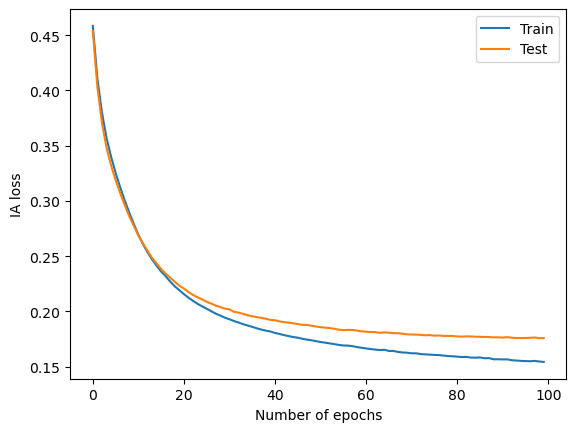

In [138]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_ia, label="Train")
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_ia, label="Test")
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("IA loss")

In [139]:
# Add category labels for IA network
bkg_test['category_ia'] = model_ia.probmax(torch.Tensor(bkg_test[features].to_numpy())).detach().numpy()
ggh_test['category_ia'] = model_ia.probmax(torch.Tensor(ggh_test[features].to_numpy())).detach().numpy()
vbf_test['category_ia'] = model_ia.probmax(torch.Tensor(vbf_test[features].to_numpy())).detach().numpy()

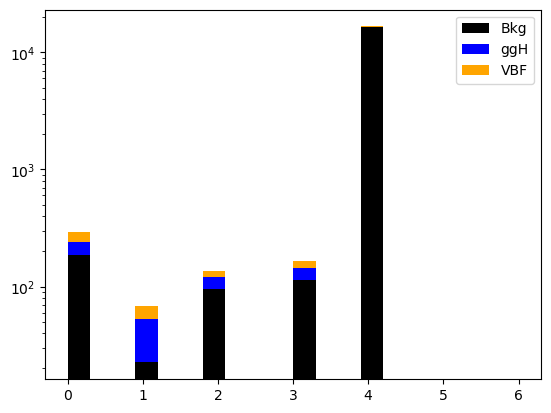

In [140]:
fig, ax = plt.subplots()
h = ax.hist([bkg_test['category_ia'],ggh_test['category_ia'],vbf_test['category_ia']], 
        bins=20, range=(0,6), 
        label=['Bkg','ggH','VBF'], color=['black','blue','orange'], 
        weights=[bkg_test['scaled_original_weight']*wf['bkg'],ggh_test['scaled_original_weight']*wf['ggh'],vbf_test['scaled_original_weight']*wf['vbf']],
        stacked=True
       )
ax.legend(loc='best')
ax.set_yscale("log")

In [144]:
yields['ia'] = {}
yields['ia']['bkg'] = np.array([])
yields['ia']['ggh'] = np.array([])
yields['ia']['vbf'] = np.array([])

for cat in [0,1,2,3,4]:
    yields['ia']['bkg'] = np.append( yields['ia']['bkg'], bkg_test[bkg_test['category_ia']==cat]['scaled_original_weight'].sum()*wf['bkg'])
    yields['ia']['ggh'] = np.append( yields['ia']['ggh'], ggh_test[ggh_test['category_ia']==cat]['scaled_original_weight'].sum()*wf['ggh'])
    yields['ia']['vbf'] = np.append( yields['ia']['vbf'], vbf_test[vbf_test['category_ia']==cat]['scaled_original_weight'].sum()*wf['vbf'])

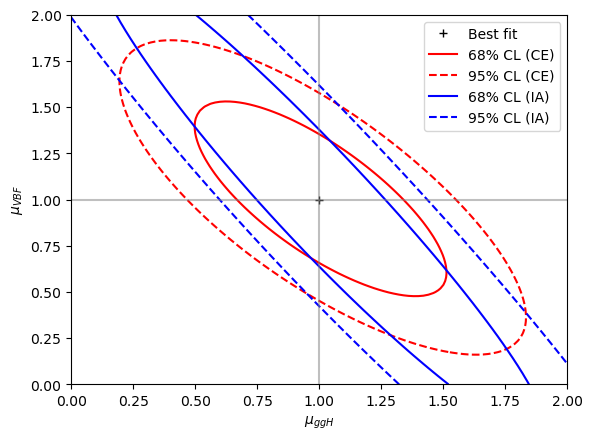

In [147]:
x = np.linspace(0,2,101)
y = np.linspace(0,2,101)
X,Y = np.meshgrid(x,y)
Z = []
for i in range(len(X)):
    z = []
    for j in range(len(X[i])):
        xval,yval = X[i][j], Y[i][j]
        z.append(NLL(yields['ia'], xval, yval, theta_init))
    Z.append(z)
nll['ia'] = np.array(Z)

fig, ax = plt.subplots()
cs = ax.contour(X,Y,TwoDeltaNLL(nll['ce']), levels=[2.3,5.99], colors=['red','red'], linestyles=['solid','dashed'])
cs = ax.contour(X,Y,TwoDeltaNLL(nll['ia']), levels=[2.3,5.99], colors=['blue','blue'], linestyles=['solid','dashed'])
i_bf, j_bf = np.unravel_index(TwoDeltaNLL(nll['ia']).argmin(), TwoDeltaNLL(nll['ia']).shape)
ax.plot(X[i_bf][j_bf], Y[i_bf][j_bf], marker='+', color='black', label='Best fit', ls='None')
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([],[], color='red', ls='solid'))
handles.append(plt.Line2D([],[], color='red', ls='dashed'))
handles.append(plt.Line2D([],[], color='blue', ls='solid'))
handles.append(plt.Line2D([],[], color='blue', ls='dashed'))
labels.append("68% CL (CE)")
labels.append("95% CL (CE)")
labels.append("68% CL (IA)")
labels.append("95% CL (IA)")
ax.legend(handles, labels, loc='best')
ax.set_xlabel("$\mu_{ggH}$")
ax.set_ylabel("$\mu_{VBF}$")
ax.axhline(theta_init['mu_ggh'], color='grey', alpha=0.5)
ax.axvline(theta_init['mu_vbf'], color='grey', alpha=0.5)

### Discussion
By setting active_args=0, the learning did not consider the impact of `mu_vbf` at all.

It picked the configuration which minimise the uncertainty in mu_ggh for mu_vbf fixed at 1. At the cost of introducing a huge anti-correlation between the parameters.

This is not what we want!

Lets now calculate the Fisher information using both mu_ggh and mu_vbf: `active_args=(0,1)`

In [152]:
model_ia_v2 = NetInferenceAware(n_features=len(features), nodes=[100,100], output_nodes=5, temp=0.1)

In [153]:
model_ia_v2, train_loss_ia_v2, test_loss_ia_v2 = train_network_inference_aware(model_ia_v2, train_df, test_df, 
                                                                               theta_init, sumw, features=features, label='Type', weight_var="scaled_original_weight", 
                                                                               train_hp=train_hp, active_args=(0,1)
                                                                              )

>> Inference-Aware training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [03:53<00:00,  1.28it/s, test_loss=tensor(0.6360), train_loss=tensor(0.4615)]

>> Training finished


Text(0, 0.5, 'IA loss')

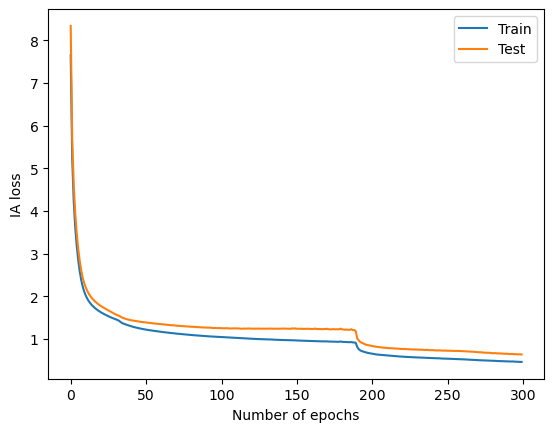

In [154]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_ia_v2, label="Train")
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_ia_v2, label="Test")
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("IA loss")

In [155]:
bkg_test['category_ia_v2'] = model_ia_v2.probmax(torch.Tensor(bkg_test[features].to_numpy())).detach().numpy()
ggh_test['category_ia_v2'] = model_ia_v2.probmax(torch.Tensor(ggh_test[features].to_numpy())).detach().numpy()
vbf_test['category_ia_v2'] = model_ia_v2.probmax(torch.Tensor(vbf_test[features].to_numpy())).detach().numpy()

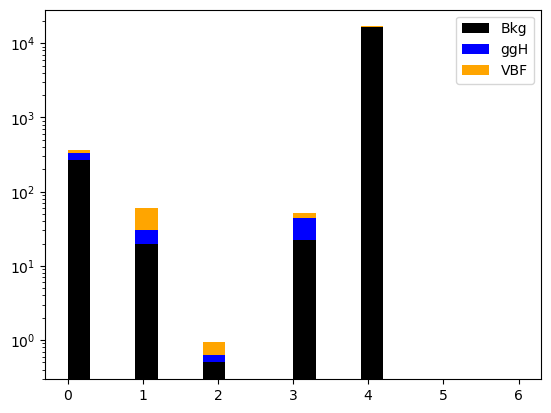

In [156]:
fig, ax = plt.subplots()
h = ax.hist([bkg_test['category_ia_v2'],ggh_test['category_ia_v2'],vbf_test['category_ia_v2']], 
        bins=20, range=(0,6), 
        label=['Bkg','ggH','VBF'], color=['black','blue','orange'], 
        weights=[bkg_test['scaled_original_weight']*wf['bkg'],ggh_test['scaled_original_weight']*wf['ggh'],vbf_test['scaled_original_weight']*wf['vbf']],
        stacked=True
       )
ax.legend(loc='best')
ax.set_yscale("log")

In [157]:
yields['ia_v2'] = {}
yields['ia_v2']['bkg'] = np.array([])
yields['ia_v2']['ggh'] = np.array([])
yields['ia_v2']['vbf'] = np.array([])

for cat in [0,1,2,3,4]:
    yields['ia_v2']['bkg'] = np.append( yields['ia_v2']['bkg'], bkg_test[bkg_test['category_ia_v2']==cat]['scaled_original_weight'].sum()*wf['bkg'])
    yields['ia_v2']['ggh'] = np.append( yields['ia_v2']['ggh'], ggh_test[ggh_test['category_ia_v2']==cat]['scaled_original_weight'].sum()*wf['ggh'])
    yields['ia_v2']['vbf'] = np.append( yields['ia_v2']['vbf'], vbf_test[vbf_test['category_ia_v2']==cat]['scaled_original_weight'].sum()*wf['vbf'])

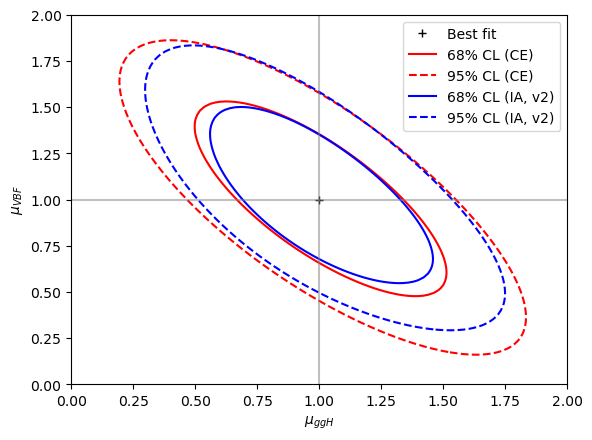

In [158]:
x = np.linspace(0,2,101)
y = np.linspace(0,2,101)
X,Y = np.meshgrid(x,y)
Z = []
for i in range(len(X)):
    z = []
    for j in range(len(X[i])):
        xval,yval = X[i][j], Y[i][j]
        z.append(NLL(yields['ia_v2'], xval, yval, theta_init))
    Z.append(z)
nll['ia_v2'] = np.array(Z)

fig, ax = plt.subplots()
cs = ax.contour(X,Y,TwoDeltaNLL(nll['ce']), levels=[2.3,5.99], colors=['red','red'], linestyles=['solid','dashed'])
cs = ax.contour(X,Y,TwoDeltaNLL(nll['ia_v2']), levels=[2.3,5.99], colors=['blue','blue'], linestyles=['solid','dashed'])
i_bf, j_bf = np.unravel_index(TwoDeltaNLL(nll['ia_v2']).argmin(), TwoDeltaNLL(nll['ia_v2']).shape)
ax.plot(X[i_bf][j_bf], Y[i_bf][j_bf], marker='+', color='black', label='Best fit', ls='None')
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([],[], color='red', ls='solid'))
handles.append(plt.Line2D([],[], color='red', ls='dashed'))
handles.append(plt.Line2D([],[], color='blue', ls='solid'))
handles.append(plt.Line2D([],[], color='blue', ls='dashed'))
labels.append("68% CL (CE)")
labels.append("95% CL (CE)")
labels.append("68% CL (IA, v2)")
labels.append("95% CL (IA, v2)")
ax.legend(handles, labels, loc='best')
ax.set_xlabel("$\mu_{ggH}$")
ax.set_ylabel("$\mu_{VBF}$")
ax.axhline(theta_init['mu_ggh'], color='grey', alpha=0.5)
ax.axvline(theta_init['mu_vbf'], color='grey', alpha=0.5)

# Discussion
Good... put still not perfect. Look at the definition of the previous InferenceAwareLoss. It was still returning just the uncertainty in the ggh signal strength.

Let's redefine to give the trace of the inverse Hessian (covariance), where the terms are sqrt to give a sum of the standard deviations.

In [159]:
# Redefine loss to be trace of terms along diagonal
def InferenceAwareLoss(X, y, w, model, theta_init, sumw, active_args=0):
    # Define parameters
    mu_ggh = torch.tensor(theta_init['mu_ggh'], requires_grad=True)
    mu_vbf = torch.tensor(theta_init['mu_vbf'], requires_grad=True)

    # Calculate fisher information: hessian of NLL function w.r.t active_args
    hess = torch.func.hessian(NLL_ia,active_args)(mu_ggh, mu_vbf, theta_init, sumw, X, y, w, model)
    
    if active_args == 0:
        return (1/hess)**0.5
    else:
        return torch.sum(torch.diag(torch.inverse(hess_to_tensor(hess)))**0.5)

In [160]:
model_ia_v3 = NetInferenceAware(n_features=len(features), nodes=[100,100], output_nodes=5, temp=0.1)

In [161]:
model_ia_v3, train_loss_ia_v3, test_loss_ia_v3 = train_network_inference_aware(model_ia_v3, train_df, test_df, theta_init, sumw, features=features, label='Type', weight_var="scaled_original_weight", train_hp=train_hp, active_args=(0,1))

>> Inference-Aware training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [03:57<00:00,  1.26it/s, test_loss=tensor(0.5889), train_loss=tensor(0.4354)]

>> Training finished


Text(0, 0.5, 'IA loss')

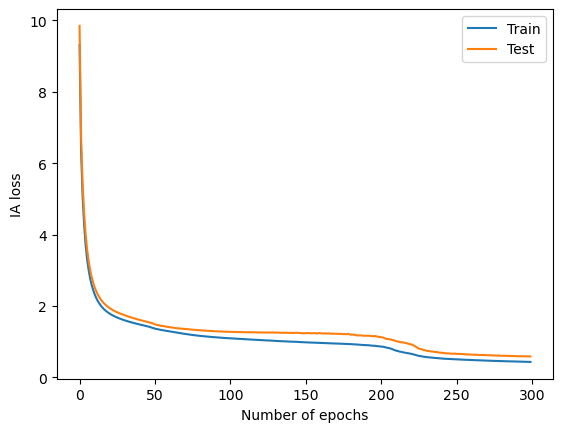

In [162]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_ia_v3, label="Train")
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_ia_v3, label="Test")
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("IA loss")
#ax.set_ylim(0,5)

In [163]:
bkg_test['category_ia_v3'] = model_ia_v3.probmax(torch.Tensor(bkg_test[features].to_numpy())).detach().numpy()
ggh_test['category_ia_v3'] = model_ia_v3.probmax(torch.Tensor(ggh_test[features].to_numpy())).detach().numpy()
vbf_test['category_ia_v3'] = model_ia_v3.probmax(torch.Tensor(vbf_test[features].to_numpy())).detach().numpy()

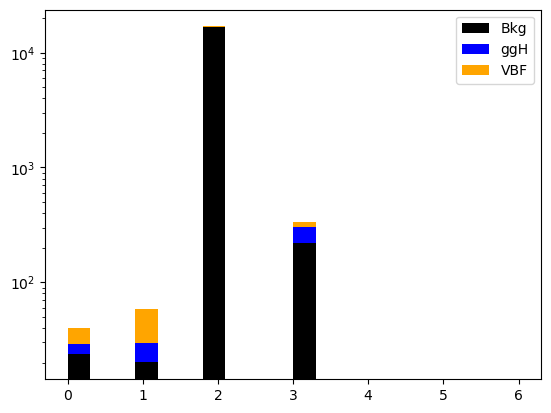

In [164]:
fig, ax = plt.subplots()
h = ax.hist([bkg_test['category_ia_v3'],ggh_test['category_ia_v3'],vbf_test['category_ia_v3']], 
        bins=20, range=(0,6), 
        label=['Bkg','ggH','VBF'], color=['black','blue','orange'], 
        weights=[bkg_test['scaled_original_weight']*wf['bkg'],ggh_test['scaled_original_weight']*wf['ggh'],vbf_test['scaled_original_weight']*wf['vbf']],
        stacked=True
       )
ax.legend(loc='best')
ax.set_yscale("log")

In [165]:
yields['ia_v3'] = {}
yields['ia_v3']['bkg'] = np.array([])
yields['ia_v3']['ggh'] = np.array([])
yields['ia_v3']['vbf'] = np.array([])

for cat in [0,1,2,3,4]:
    yields['ia_v3']['bkg'] = np.append( yields['ia_v3']['bkg'], bkg_test[bkg_test['category_ia_v3']==cat]['scaled_original_weight'].sum()*wf['bkg'])
    yields['ia_v3']['ggh'] = np.append( yields['ia_v3']['ggh'], ggh_test[ggh_test['category_ia_v3']==cat]['scaled_original_weight'].sum()*wf['ggh'])
    yields['ia_v3']['vbf'] = np.append( yields['ia_v3']['vbf'], vbf_test[vbf_test['category_ia_v3']==cat]['scaled_original_weight'].sum()*wf['vbf'])

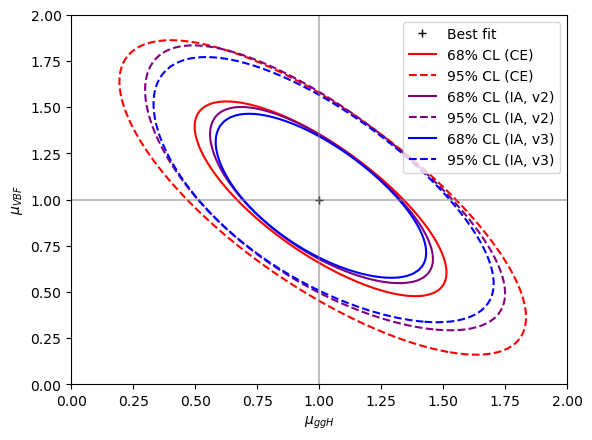

In [168]:
x = np.linspace(0,2,101)
y = np.linspace(0,2,101)
X,Y = np.meshgrid(x,y)
Z = []
for i in range(len(X)):
    z = []
    for j in range(len(X[i])):
        xval,yval = X[i][j], Y[i][j]
        z.append(NLL(yields['ia_v3'], xval, yval, theta_init))
    Z.append(z)
nll['ia_v3'] = np.array(Z)

fig, ax = plt.subplots()
cs = ax.contour(X,Y,TwoDeltaNLL(nll['ce']), levels=[2.3,5.99], colors=['red','red'], linestyles=['solid','dashed'])
cs = ax.contour(X,Y,TwoDeltaNLL(nll['ia_v2']), levels=[2.3,5.99], colors=['purple','purple'], linestyles=['solid','dashed'])
cs = ax.contour(X,Y,TwoDeltaNLL(nll['ia_v3']), levels=[2.3,5.99], colors=['blue','blue'], linestyles=['solid','dashed'])
i_bf, j_bf = np.unravel_index(TwoDeltaNLL(nll['ia_v3']).argmin(), TwoDeltaNLL(nll['ia_v3']).shape)
ax.plot(X[i_bf][j_bf], Y[i_bf][j_bf], marker='+', color='black', label='Best fit', ls='None')
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([],[], color='red', ls='solid'))
handles.append(plt.Line2D([],[], color='red', ls='dashed'))
handles.append(plt.Line2D([],[], color='purple', ls='solid'))
handles.append(plt.Line2D([],[], color='purple', ls='dashed'))
handles.append(plt.Line2D([],[], color='blue', ls='solid'))
handles.append(plt.Line2D([],[], color='blue', ls='dashed'))
labels.append("68% CL (CE)")
labels.append("95% CL (CE)")
labels.append("68% CL (IA, v2)")
labels.append("95% CL (IA, v2)")
labels.append("68% CL (IA, v3)")
labels.append("95% CL (IA, v3)")
ax.legend(handles, labels, loc='best')
ax.set_xlabel("$\mu_{ggH}$")
ax.set_ylabel("$\mu_{VBF}$")
ax.axhline(theta_init['mu_ggh'], color='grey', alpha=0.5)
ax.axvline(theta_init['mu_vbf'], color='grey', alpha=0.5)